## Pense como um Cientista de Dados
### Modelos de Árvore e Otimização Bayesiana para Classificação Binária: Casos Práticos no Mundo dos Negócios

### <font color = 'blue'>Capítulo 2. Implementação do Algoritmo com Modelos de Ensemble e SHAP</font>

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,xgboost -u -n -t -z

Last updated: Fri Sep 20 2024 21:53:12-03

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

numpy       : 1.26.4
pandas      : 2.2.2
scikit-learn: 1.4.2
xgboost     : 2.1.1



### 1. Importando as Bibliotecas Necessárias

In [2]:
import pandas as pd
import numpy as np
import re
import shap
import matplotlib.pyplot as plt
from typing import Tuple, Any
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

In [3]:
# Para reprodutibilidade
SEED = 42

### 2. Carregando o Conjunto de Dados

In [4]:
def prepare_heart_disease_data():
    # URL do dataset
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
    
    # Nome das colunas
    feature_names = ['Age', 'Sex', 'Chest_Pain_Type', 'Resting_BP', 'Serum_Cholesterol', 
               'Fasting_Blood_Sugar', 'Resting_ECG', 'Max_Heart_Rate', 
               'Exercise_Induced_Angina', 'ST_Depression', 'Slope_ST_Segment', 
               'Number_Major_Vessels', 'Thalassemia', 'target']

    # Carregar o dataset
    df = pd.read_csv(url, names=feature_names)
    
    # Tratar valores ausentes (substituir '?' por NaN)
    df.replace('?', np.nan, inplace=True)
    
    # Preencher valores ausentes com a moda, sem inplace
    for col in ['Number_Major_Vessels', 'Thalassemia']:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Converter colunas para numérico
    df = df.apply(pd.to_numeric)
    
    # Mapear a coluna 'target' para binário (0: sem doença, 1: com doença)
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Separar X e y
    X = df.drop('target', axis=1)
    y = df['target']
    
    return X, y

# Preparar os dados
X, y = prepare_heart_disease_data()

### 3. Preparação dos Dados

In [5]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalização das variáveis numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balanceamento das classes com SMOTE (opcional, dependendo do desbalanceamento)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Implementando e Otimizando os Modelos de Ensemble
### 1. Definindo a Função para encontrar o melhor *threshold*

In [6]:
# Função para otimizar modelos e calcular o melhor threshold
def find_best_threshold(y_true: np.ndarray, y_scores: np.ndarray, metric: str = 'f1') -> Tuple[float, float]:
    """
    Função para encontrar o melhor threshold para a métrica escolhida (f1, precisão, recall).
    """
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred)
        scores.append(score)

    best_idx = np.argmax(scores)
    
    return thresholds[best_idx], scores[best_idx]

### 2. Definindo a Função para Encontrar o Melhor Modelo e Avaliação

In [7]:
def optimize_ensemble_models(X_train_res, X_test_scaled, y_train_res, y_test, metric='f1'):
    param_spaces = {
        'random_forest': {
            'n_estimators': (10, 2000),
            'max_depth': (None, 5, 10, 20, 30),
            'min_samples_split': (2, 5, 10, 20)
        },
        'adaboost': {
            'n_estimators': (10, 1000),
            'learning_rate': (0.01, 1.0)
        },
        'xgboost': {
            'n_estimators': (100, 2000),
            'max_depth': (3, 20),
            'learning_rate': (0.01, 0.3),
            'subsample': (0.2, 1.0)
        }
    }

    best_auc = 0
    best_model = None

    models = {
        'random_forest': RandomForestClassifier(random_state=SEED),
        'adaboost': AdaBoostClassifier(algorithm='SAMME', random_state=SEED),
        'xgboost': XGBClassifier(eval_metric='logloss', random_state=SEED)
    }

    for model_name, model in models.items():
        bayes_search = BayesSearchCV(model, param_spaces[model_name], 
                                     n_iter=30, scoring='roc_auc', cv=5, n_jobs=-1, random_state=SEED)
        bayes_search.fit(X_train_res, y_train_res)
        best_params = bayes_search.best_params_

        model.set_params(**best_params)
        model.fit(X_train_res, y_train_res)

        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"{model_name} AUC: {auc_score:.4f}")

        if auc_score > best_auc:
            best_auc = auc_score
            best_model = model

    print(f"\nMelhor modelo: {type(best_model).__name__} com AUC: {best_auc:.4f}")

    best_threshold, best_metric_score = find_best_threshold(y_test, y_pred_proba, metric=metric)
    y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    cm = confusion_matrix(y_test, y_pred_adjusted)

    print(f"\nThreshold ótimo ({metric}): {best_threshold:.2f}")
    print("\nMatriz de Confusão Ajustada:")
    print(cm)
    print(f"\nPrecisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc="lower right")
    plt.show()

    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_curve, precision_curve, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.title(f'Curva Precision-Recall')
    plt.show()

    return best_model, X_test_scaled, y_test

### 3. Interpretabilidade com SHAP

In [8]:
def explain_model(best_model: Any, X_test: np.ndarray, feature_names: list):
    """
    Gera gráficos SHAP para interpretar o modelo treinado.
    """
    X_test_dense = pd.DataFrame(X_test.toarray() if isinstance(X_test, csr_matrix) else X_test, columns=feature_names)
    X_test_dense = X_test_dense.apply(pd.to_numeric, errors='coerce')

    if isinstance(best_model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_dense)
        shap_values_class_1 = shap_values[:, :, 1] if isinstance(best_model, RandomForestClassifier) else shap_values
    elif isinstance(best_model, AdaBoostClassifier):
        # Reduzir o background usando K-means com 10 clusters
        background = shap.kmeans(X_train, 10)
        explainer = shap.KernelExplainer(best_model.predict_proba, background)
        shap_values = explainer.shap_values(X_test_dense)
        shap_values_class_1 = shap_values[:, :, 1]
    else:
        raise ValueError(f"Modelo {type(best_model)} não suportado.")

    shap.summary_plot(shap_values_class_1, X_test_dense, show=False)
        
    plt.show()
        
    # Calcular a média dos valores SHAP ao longo de todas as amostras para obter a importância das features
    shap_values_mean = np.mean(shap_values_class_1, axis=0)
    
    # Gerar o gráfico de barras horizontais
    shap.bar_plot(shap_values_mean, feature_names=feature_names, max_display=20, show=False)
    
    plt.show()
    
    # Retornar os valores SHAP para uso posterior
    return shap_values_class_1, X_test_dense  # Aqui é onde garantimos o retorno

### Executando o Código Completo

random_forest AUC: 0.9252
adaboost AUC: 0.9150
xgboost AUC: 0.9184

Melhor modelo: RandomForestClassifier com AUC: 0.9252

Threshold ótimo (f1): 0.42

Matriz de Confusão Ajustada:
[[39 10]
 [ 5 37]]

Precisão: 0.7872
Recall: 0.8810
F1-Score: 0.8315


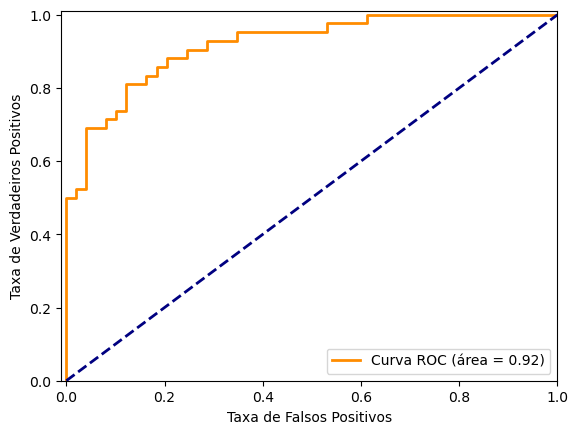

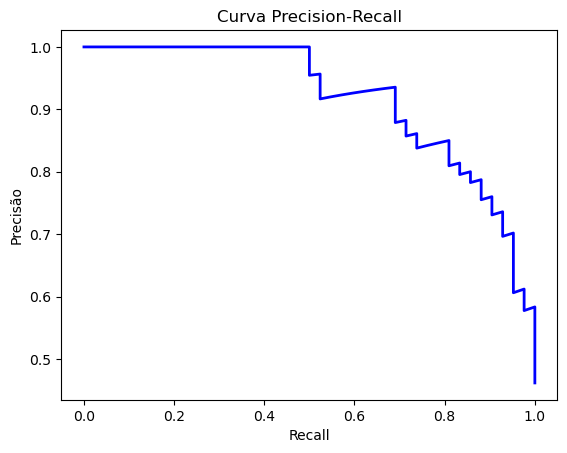

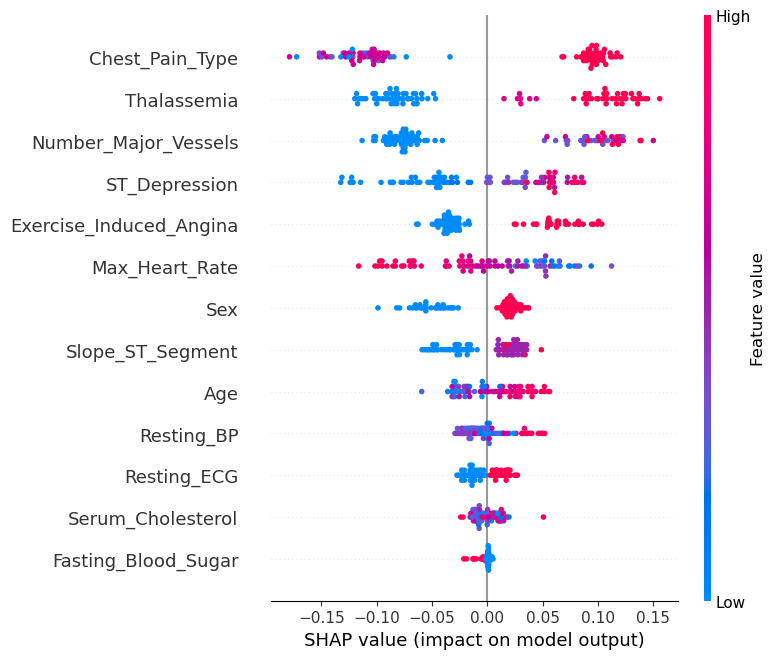

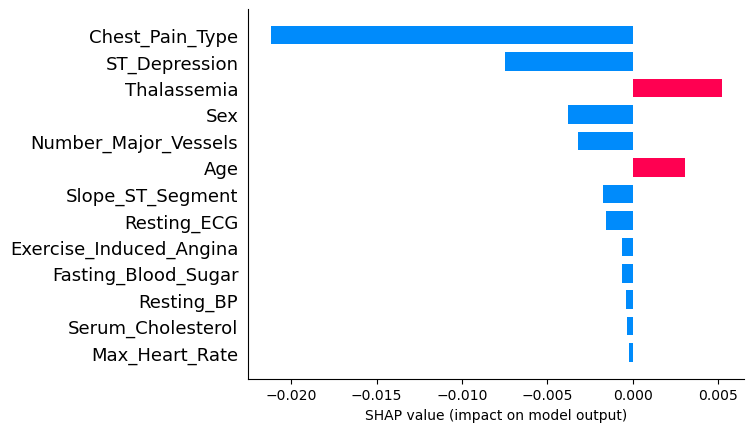

CPU times: user 2min 24s, sys: 3.33 s, total: 2min 28s
Wall time: 1min 47s


In [9]:
%%time
# Nome das variáveis
feature_names = X.columns

# Otimizar modelos e encontrar o melhor
best_model, X_test, y_test = optimize_ensemble_models(X_train_res, X_test, y_train_res, y_test)

# Interpretabilidade com SHAP
# Chamar a função sem imprimir os retornos
shap_values_class_1, X_test_dense = explain_model(best_model, X_test, feature_names)

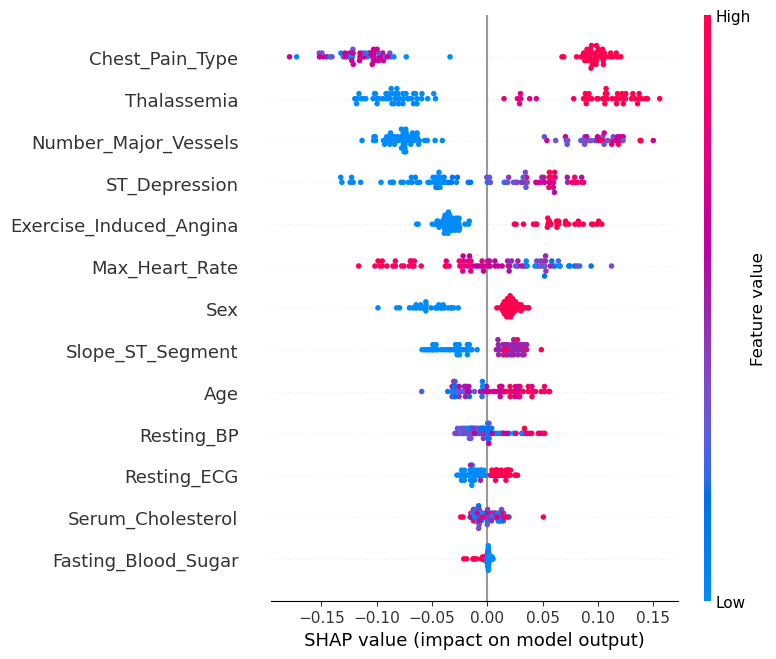

In [10]:
# Gerar gráfico de SHAP

shap.summary_plot(shap_values_class_1, X_test_dense, show=False)
    
# Salvar o gráfico gerado em PNG
plt.savefig('images/shap_summary_plot.png', format='png', dpi=300, bbox_inches='tight')

# Exibir o gráfico
plt.show()

# Fechar o gráfico para liberar memória
plt.close()

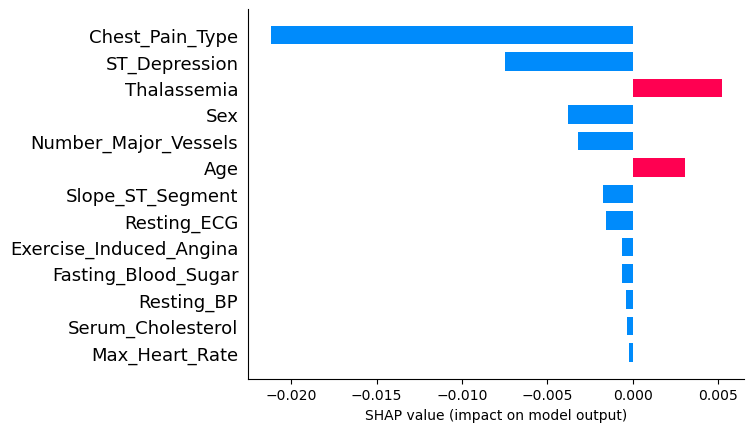

In [11]:
# Gerar gráfico de SHAP

shap_values_mean = np.mean(shap_values_class_1, axis=0)

shap.bar_plot(shap_values_mean, feature_names=feature_names, max_display=20, show=False)

# Salvar o gráfico em PNG antes de exibir
plt.savefig('images/shap_summary_bar_plot.png', format='png', dpi=300, bbox_inches='tight')

# Exibir o gráfico
plt.show()

# Fechar o gráfico para liberar memória
plt.close()
